In [8]:
import sys
import torch
import numpy as np

import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
import torchvision.transforms.functional as F_t

import warnings
warnings.filterwarnings("ignore")

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import random
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.transforms import ToPILImage

import torchvision.utils as vutils
import torch.nn.functional as F

# Loading the classifier:

In [2]:
class NormalizeSingleChannel(object):
    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.std = std
        self.inplace = inplace

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image to be normalized.

        Returns:
            Tensor: Normalized Tensor image.
        """
        if not isinstance(tensor, torch.Tensor):
            raise TypeError(f"img should be Tensor Image. Got {type(tensor)}")

        if tensor.ndim == 3:  # For single-channel input tensor
            tensor = tensor.unsqueeze(0)  # Add batch dimension

        if tensor.ndim != 4 or tensor.shape[1] != 1:
            raise ValueError("Input tensor shape should be [1, H, W]")

        mean = torch.as_tensor(self.mean, dtype=torch.float32, device=tensor.device)
        std = torch.as_tensor(self.std, dtype=torch.float32, device=tensor.device)

        # Broadcast mean and std to match tensor shape
        mean = mean.view(-1, 1, 1)
        std = std.view(-1, 1, 1)

        if self.inplace:
            tensor.sub_(mean).div_(std)
            return tensor
        else:
            return F_t.normalize(tensor, mean, std, self.inplace)

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(),        # Convert images to grayscale
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=15), 
    transforms.Resize((224, 224)),   # Resize images to 224x224 (or any appropriate size for your model)
    transforms.ToTensor(),         # Convert images to tensors
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize images
])

# Load FER2013 dataset
fer2013_df = pd.read_csv('fer2013.csv')

target_emotions = [0, 3, 4]  # 0: anger, 3: happiness, 4: sadness
filtered_df = fer2013_df[fer2013_df['emotion'].isin(target_emotions)] 

# Define a mapping dictionary
mapping = {0: 0, 3: 1, 4: 2}
# Apply the mapping to the dataset labels
filtered_df['emotion'] = filtered_df['emotion'].map(mapping)


In [4]:
# Define custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.to_pil = ToPILImage()  # Instantiate ToPILImage transformer
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = np.array(self.dataframe.iloc[idx, 1].split(), dtype=np.uint8).reshape(48, 48)
        label = int(self.dataframe.iloc[idx, 0])  # No need to subtract 1 from the label

        # Convert NumPy array to PIL Image
        image = self.to_pil(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


# Create custom dataset and apply transformations
custom_dataset = CustomDataset(filtered_df, transform=transform)

In [5]:
# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(custom_dataset))
val_size = int(0.15 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    custom_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [6]:
class EfficientNetGray(nn.Module):
    def __init__(self, model_name='efficientnet-b0', num_classes=7):
        super(EfficientNetGray, self).__init__()
        self.model = EfficientNet.from_name(model_name)
        self.model._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, bias=False)
        num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Linear(num_ftrs, num_classes)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.batch_norm = nn.BatchNorm2d(num_ftrs)  # Batch normalization layer

    def forward(self, x):
        x = self.model.extract_features(x)
        x = self.batch_norm(x)  # Batch normalization after the features are extracted
        x = self.model._avg_pooling(x)
        x = x.flatten(start_dim=1)
        x = self.dropout(x)
        x = self.model._dropout(x)
        x = self.model._fc(x)
        return x

In [7]:
# Load the saved classifier model state dictionary
model_classifier = EfficientNetGray()
model_classifier.load_state_dict(torch.load('newest_model_efficientnet.pth', map_location=torch.device('cpu')))
model_classifier.eval();

EfficientNetGray(
  (model): EfficientNet(
    (_conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding(
          32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
        

# Loading the Emopia Transformer 
#### https://github.com/annahung31/EMOPIA/blob/main/workspace/transformer/generate.ipynb

In [17]:
from midiSynth.synth import MidiSynth
import os
import pickle
from utils import write_midi
from models import TransformerModel, network_paras

In [15]:
path_dictionary = 'emopia/co-representation/dictionary.pkl'
assert os.path.exists(path_dictionary)

In [18]:
dictionary = pickle.load(open(path_dictionary, 'rb'))
event2word, word2event = dictionary

In [19]:
# config
n_class = []   # num of classes for each token
for key in event2word.keys():
    n_class.append(len(dictionary[0][key]))
n_token = len(n_class)

In [33]:
path_saved_ckpt = 'emopia/loss_25_params.pt'
assert os.path.exists(path_saved_ckpt)

In [35]:
# init model
net = TransformerModel(n_class, is_training=False)
net.cuda()
net.eval()

net.load_state_dict(torch.load(path_saved_ckpt))

>>>>>: [56, 135, 18, 4, 87, 18, 42, 5]
 [o] using RNN backend.


<All keys matched successfully>

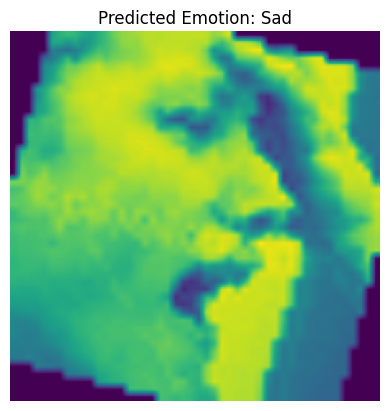

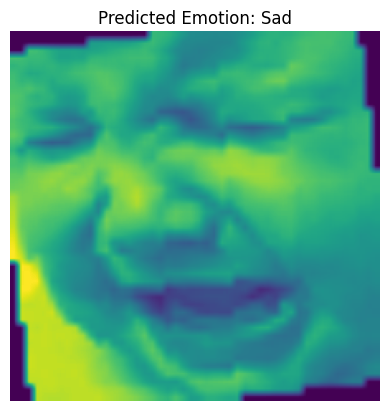

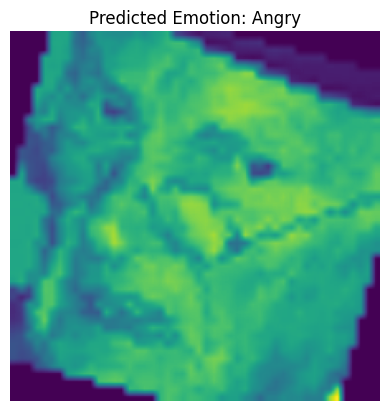

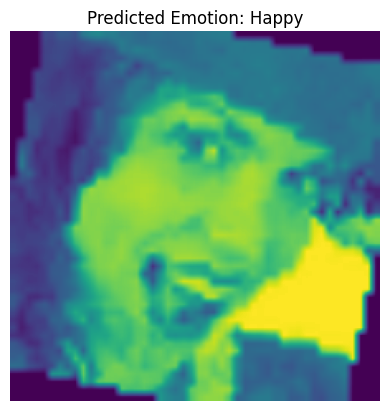

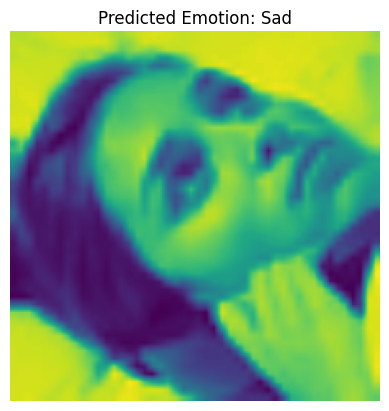

In [13]:
# Define emotion labels
emotion_labels = {0: 'Angry', 3: 'Happy', 4: 'Sad'}

# Get 5 random samples from the test dataset
num_samples = 4
random_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

# Iterate over the random indices
for idx in random_indices:
    image, label = test_dataset[idx]
    
    # Add batch dimension
    image = image.unsqueeze(0)
    
    # Move image to GPU if available
    image = image.to(device)
    
    # Perform inference
    with torch.no_grad():
        output = model_classifier(image)
    
    # Get predicted label
    _, predicted = torch.max(output, 1)
    
    # Reverse map predicted label to original label
    original_label = reverse_mapping[predicted.item()]
    
    # Convert original label to emotion
    predicted_emotion = emotion_labels[original_label]
    
    # Convert image tensor to numpy array
    image_np = image.squeeze(0).cpu().numpy()
    
    # Transpose image array to (height, width, channels)
    image_np = np.transpose(image_np, (1, 2, 0))
    
    # Display the image and predicted emotion
    plt.imshow(image_np)
    plt.title(f'Predicted Emotion: {predicted_emotion}')
    plt.axis('off')
    plt.show()

    # Convert predicted emotion to random melody index
    if predicted_emotion == 'Happy':
        emotion_tag = 1 
    elif predicted_emotion == 'Angry':
        emotion_tag = 2 
    elif predicted_emotion == 'Sad':
        emotion_tag = 3 
    else:
        # Handle unknown emotion
        emotion_tag = 4 
    
    # Generate and save as MIDI
    filename = f"{predicted_emotion}{idx}.mid" 
    res, _ = net.inference_from_scratch(dictionary, emotion_tag, n_token=8, display=False)
    write_midi(res, filename, word2event)